# Cat Tree Reviews to Images

### Import libraries

In [1]:
!pip install sentence-transformers faiss-cpu scikit-learn -q

In [2]:
!pip install scikit-learn matplotlib seaborn -q

In [80]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
import faiss
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import openai

/opt/miniconda3/envs/genAi_final_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1 - Preprocessing Reviews

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully")

In [9]:
csv_path = 'walmart.csv'
df = pd.read_csv(csv_path)

In [10]:
df

date        user_name  \
0     21-Oct-25  WalmartCustomer   
1     11-Jul-25       bernadette   
2      8-Jun-25            Julie   
3     10-Mar-25             Rita   
4     11-Nov-24  WalmartCustomer   
...         ...              ...   
2100  15-Apr-23         Virginia   
2101   3-Jan-24            James   
2102  18-May-23          William   
2103   9-Oct-23            Ernie   
2104   4-Apr-23          Bharath   

                                                content  \
0     I recently got my hands on the MyMini 7-Egg Co...   
1     Wish I had found this years ago. No boiling wa...   
2     Cute and easy to use little egg cooker. \nIt h...   
3     this egg cooker is awesome! its super easy to ...   
4     The product is great but charging me more for ...   
...                                                 ...   
2100       1 article was missing. Old fashioned oatmeal   
2101  it's a great having a granddaughter loves it g...   
2102                         Easy To Use Good Quality !   
2103  Pretty cool gadget..quickly hard boils eggs......   
2104  worst pickup experience. took almost an hour t...   

                         rate                 b 2                    title  
0     5 out of 5 stars review   Verified Purchase                      NaN  
1     5 out of 5 stars review   Verified Purchase                      NaN  
2     5 out of 5 stars review   Verified Purchase  Great little egg cooker  
3     5 out of 5 stars review   Verified Purchase                      NaN  
4     4 out of 5 stars review   Verified Purchase                      NaN  
...                       ...                 ...                      ...  
2100                      NaN                Yay!                      NaN  
2101                      NaN   Love this product                      NaN  
2102                      NaN        Perfect Eggs                      NaN  
2103                      NaN  Perfect Every Time                      NaN  
2104                      NaN                 NaN                      NaN  

[2105 rows x 6 columns]

In [11]:
# Extract and clean reviews column
df_reviews = df[['content']].copy()

# Remove rows with NaN values
df_reviews = df_reviews.dropna()

# Rename column to 'review'
df_reviews = df_reviews.rename(columns={'content': 'review'})

# Reset index after dropping NaN
df_reviews = df_reviews.reset_index(drop=True)

df_reviews

review
0     I recently got my hands on the MyMini 7-Egg Co...
1     Wish I had found this years ago. No boiling wa...
2     Cute and easy to use little egg cooker. \nIt h...
3     this egg cooker is awesome! its super easy to ...
4     The product is great but charging me more for ...
...                                                 ...
2097       1 article was missing. Old fashioned oatmeal
2098  it's a great having a granddaughter loves it g...
2099                         Easy To Use Good Quality !
2100  Pretty cool gadget..quickly hard boils eggs......
2101  worst pickup experience. took almost an hour t...

[2102 rows x 1 columns]

In [12]:
# Save cleaned data
output_path = 'cleaned_walmart_reviews.csv'
df_reviews[['review']].to_csv(output_path, index=False)
print(f"\nCleaned reviews saved to: {output_path}")


Cleaned reviews saved to: cleaned_walmart_reviews.csv


## Part 2 - LLM Analysis of Reviews

### Combine all reviews

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully")

In [13]:
csv_path = 'cleaned_walmart_reviews.csv'
df_reviews = pd.read_csv(csv_path)
# df_reviews = df_reviews.sample(n=800, random_state=42)   # 随机抽样 800 条
# df_reviews = df_reviews.reset_index(drop=True)

In [14]:
df_reviews

review
0     I recently got my hands on the MyMini 7-Egg Co...
1     Wish I had found this years ago. No boiling wa...
2     Cute and easy to use little egg cooker. \nIt h...
3     this egg cooker is awesome! its super easy to ...
4     The product is great but charging me more for ...
...                                                 ...
2097       1 article was missing. Old fashioned oatmeal
2098  it's a great having a granddaughter loves it g...
2099                         Easy To Use Good Quality !
2100  Pretty cool gadget..quickly hard boils eggs......
2101  worst pickup experience. took almost an hour t...

[2102 rows x 1 columns]

In [16]:
# Combine all reviews into one large text corpus
all_reviews_text = "\n\n---REVIEW---\n\n".join(df_reviews['review'].tolist())

print(f"Total reviews: {len(df_reviews)}")
print(f"Combined text length: {len(all_reviews_text)} characters")
print(f"Estimated tokens: ~{len(all_reviews_text) // 4}")  # Rough estimate: 1 token ≈ 4 chars

# Preview combined text
print("\n--- First 2000 characters of combined reviews ---")
print(all_reviews_text[:2000])

Total reviews: 2102
Combined text length: 319149 characters
Estimated tokens: ~79787

--- First 2000 characters of combined reviews ---
I recently got my hands on the MyMini 7-Egg Cooker, and I have to say, I'm pretty pleased overall! 👍 The quality of the cooker seems top-notch, and it's holding up well so far. The price was also reasonable, making it a great value for what it offers. 🍳 I'm really happy with how easy it is to use, especially on busy mornings! I'm rating it good because it has definitely earned its place in my kitchen.

---REVIEW---

Wish I had found this years ago. No boiling water. Faster than boiling water, cooks to how you want them, 7 eggs at at time or less if you want, shells slid off , you just have to dry the cover when the cooker cools down. So small, fits anywhere in the small box. I have been giving them as a "just because" gift for family and friends. Just because they are the best thing I've bought in years and use it at least once a week. It does more tha

### Visualization - Embedding & Clustering Analysis

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_reviews['review'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 66/66 [00:02<00:00, 28.68it/s]


In [18]:
# 转成 float32
embeddings_np = np.array(embeddings, dtype='float32')

# 归一化（使得点积 = cosine 相似度）
faiss.normalize_L2(embeddings_np)

d = embeddings_np.shape[1]  # 向量维度，例如 384

# 用内积索引（余弦相似度）
index = faiss.IndexFlatIP(d)

# 把所有 review 的 embedding 加进索引
index.add(embeddings_np)

print("Total vectors in index:", index.ntotal)

Total vectors in index: 2102


In [19]:
def search_reviews(query, top_k=50):
    # 编码 query
    q_emb = model.encode([query], convert_to_numpy=True)
    q_emb = q_emb.astype('float32')
    faiss.normalize_L2(q_emb)

    # 在 FAISS 中检索
    scores, indices = index.search(q_emb, top_k)  # scores shape: (1, top_k)
    
    indices = indices[0]
    scores = scores[0]
    
    # 取出对应的评论
    results = df_reviews.iloc[indices].copy()
    results['score'] = scores
    return results

In [20]:
test_query = "descriptions of the egg cooker's appearance, structure, platforms, color, materials, design"
res = search_reviews(test_query, top_k=10)
res[['review', 'score']].head()

review     score
455              This is a very good unique egg cooker.  0.720325
462   Great little egg cooker.  Works perfectly and ...  0.697742
1562  love this egg cooker its qiuck and efficient a...  0.687020
833   Great little egg cooker.  We love eggs and thi...  0.685999
459                       This egg cooker is AMAZING!!!  0.677194

In [21]:
visual_query = """
Reviews describing how the egg cooker operates:
boiling eggs, steaming eggs, omelet tray, poaching cups, noise level,
doneness levels, heating performance, capacity, steam vent, buzzer sound,
cooking consistency, speed, ease of use.
"""
functional_query = """Descriptions of the egg cooker’s visual appearance and physical structure:
shape of the cooker, dome lid, transparent or opaque lid, egg tray design, heating plate,
color of the unit, size and dimensions, number of eggs it holds, materials, buttons, lights,
overall build, body shape, and design style."""

materials_query = """Comments about the materials, textures, and build quality:
plastic lid, stainless steel heating plate, thickness of the base,
durability, sturdiness, quality of the egg tray, condensation on lid,
how solid or cheap the cooker feels, and overall craftsmanship."""

positive_query = """Reviews praising the egg cooker’s visual design:
clean look, sleek appearance, modern style, compact size, neat egg tray layout,
nice color, visually appealing lid, cute or attractive design."""

negative_query = """Complaints about the egg cooker’s appearance or structure:
too small, looks cheap, flimsy lid, poorly designed egg tray,
unstable base, low-quality plastic, uneven cooking, foggy lid,
messy condensation, scratches, dents, color mismatch."""


top_visual_reviews = search_reviews(visual_query, top_k=400)
top_function_reviews = search_reviews(functional_query, top_k=400)
top_materials_reviews = search_reviews(materials_query, top_k=400)
top_positive_reviews = search_reviews(positive_query, top_k=150)
top_negative_reviews = search_reviews(negative_query, top_k=50)

print("Retrieved visual-related reviews:", len(top_visual_reviews))
print("Retrieved functional-related reviews:", len(top_function_reviews))
print("Retrieved materials-related reviews:", len(top_materials_reviews))
print("Retrieved positive design reviews:", len(top_positive_reviews))
print("Retrieved negative design reviews:", len(top_negative_reviews))

Retrieved visual-related reviews: 400
Retrieved functional-related reviews: 400
Retrieved materials-related reviews: 400
Retrieved positive design reviews: 150
Retrieved negative design reviews: 50


In [22]:
# 1. 合并三类视觉相关评论
core_visual_df = pd.concat(
    [top_visual_reviews, top_function_reviews, top_materials_reviews],
    ignore_index=True
)

print("合并后（含重复）的条数：", len(core_visual_df))

# 2. 去重（同一条评论可能被多次检索到）
core_visual_df = core_visual_df.drop_duplicates(subset=['review']).reset_index(drop=True)
print("去重后视觉相关评论数：", len(core_visual_df))

max_core_reviews = 500
if len(core_visual_df) > max_core_reviews:
    core_visual_df = core_visual_df.sample(n=max_core_reviews, random_state=42).reset_index(drop=True)
    print("Random sample 后视觉相关评论数：", len(core_visual_df))


合并后（含重复）的条数： 1200
去重后视觉相关评论数： 577
Random sample 后视觉相关评论数： 500


In [23]:
all_core_reviews_text = "\n\n---REVIEW---\n\n".join(core_visual_df['review'].tolist())
all_reviews_text = all_core_reviews_text
print("最终视觉语料字符数：", len(all_reviews_text))
print("大致 token 数：", len(all_reviews_text) // 4)


最终视觉语料字符数： 111401
大致 token 数： 27850


In [61]:
# KMeans clustering
from sklearn.cluster import KMeans
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster column to dataframe
df_reviews['cluster'] = cluster_labels

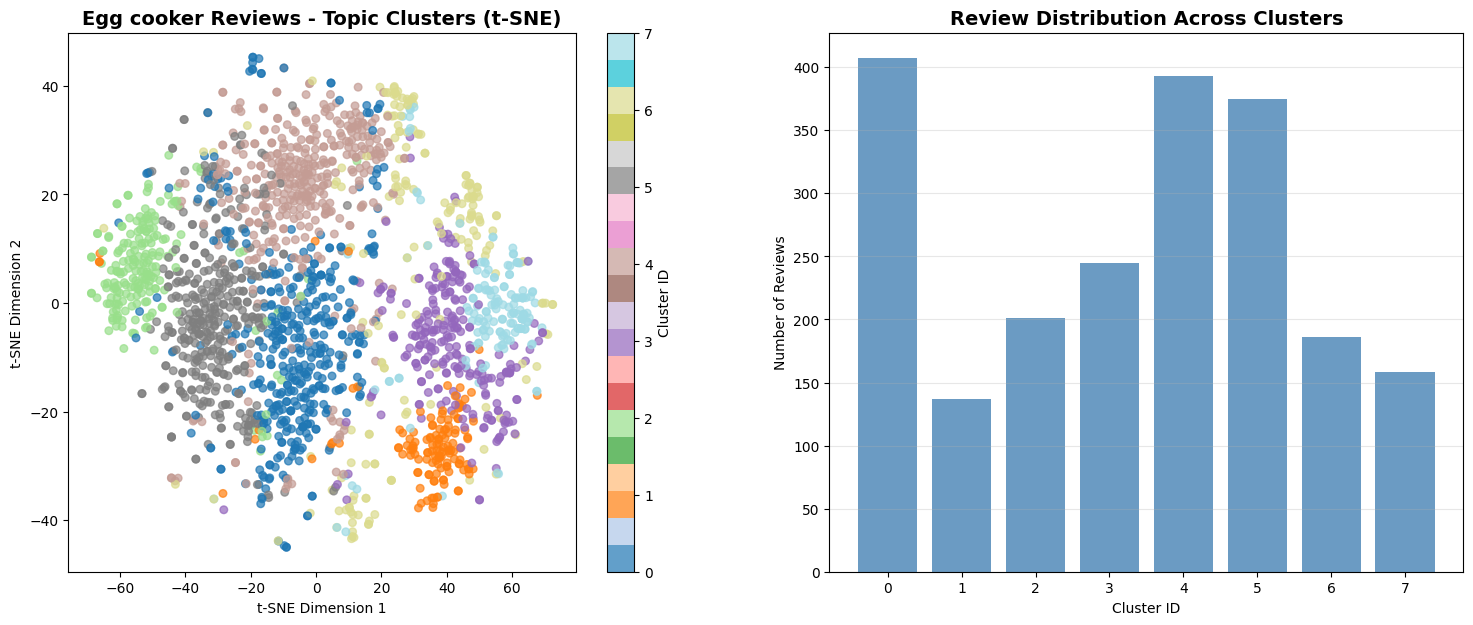

In [62]:
# PART 1: Visualization - Embedding & Clustering Analysis

# Visualize clusters using t-SNE (2D projection)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Cluster distribution
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=df_reviews['cluster'], cmap='tab20', alpha=0.7, s=30)
axes[0].set_title('Egg cooker Reviews - Topic Clusters (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

# Plot 2: Cluster size distribution
cluster_counts = df_reviews['cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.8)
axes[1].set_title('Review Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Reviews')
axes[1].grid(axis='y', alpha=0.3)


In [94]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
score = silhouette_score(embeddings, cluster_labels)
print("Silhouette Score:", score)


print("CH Score:", calinski_harabasz_score(embeddings, cluster_labels))
print("DB Score:", davies_bouldin_score(embeddings, cluster_labels))

Silhouette Score: 0.04490712285041809
CH Score: 95.15264892578125
DB Score: 3.682014979654795


In [28]:
# Extract and display sample reviews from each cluster (topic analysis)
print("CLUSTER TOPIC ANALYSIS")

cluster_topics = {}
for cluster_id in range(n_clusters):
    cluster_reviews = df_reviews[df_reviews['cluster'] == cluster_id]
    # Get a representative sample
    sample_review = cluster_reviews['review'].iloc[0]
    cluster_topics[cluster_id] = {
        'count': len(cluster_reviews),
        'sample': sample_review[:150] + "..." if len(sample_review) > 150 else sample_review
    }
    print(f"\nCluster {cluster_id} ({cluster_topics[cluster_id]['count']} reviews):")
    print(f"  Sample: {cluster_topics[cluster_id]['sample']}")

CLUSTER TOPIC ANALYSIS


KeyError: 'cluster'

In [27]:
n_clusters = 8
total_target = 800
per_cluster = total_target // n_clusters  # 这里就是 100

sampled_dfs = []

for c in range(n_clusters):
    cluster_df = df_reviews[df_reviews['cluster'] == c]
    # 从每个簇里随机抽 per_cluster 条
    sampled_cluster = cluster_df.sample(n=per_cluster, random_state=42)
    sampled_dfs.append(sampled_cluster)

df_sampled = pd.concat(sampled_dfs, ignore_index=True)

print("总共抽到的评论数：", len(df_sampled))
print(df_sampled['cluster'].value_counts().sort_index())

all_reviews_text = "\n\n---REVIEW---\n\n".join(df_sampled['review'].tolist())

KeyError: 'cluster'

### OpenAI API analysis

In [32]:
# from google.colab import userdata
# OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
# os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
# print("OpenAI API key loaded")

# from openai import OpenAI
# client = OpenAI(api_key=OPENAI_API_KEY)

In [24]:
# !pip install openai python-dotenv
import os
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

In [102]:
# Prepare the analysis prompt
# Prompt 1
analysis_prompt = f"""You are an expert product analyst. Analyze the following {len(df_sampled)} customer reviews for an egg cooker.

Your task is to extract VISUAL and STRUCTURAL information useful for generating product images. Focus on:

1. **Structure & Dimensions**: Height, number of levels/tiers, platform arrangement, base design
2. **Materials & Textures**: Fabric types (plush, carpet, sisal), surface textures
3. **Key Components**: Scratching posts, cat houses/condos, perches, ladders, hammocks
4. **Design Elements**: Hanging toys, pom-poms, color schemes, platform shapes
5. **Overall Aesthetic**: Sturdy/wobbly, compact/spacious style

Provide a JSON output with this structure:
{{
  "structure": {{
    "height": "description",
    "tiers": "number and arrangement",
    "base": "stability and design"
  }},
  "materials": {{
    "primary_covering": "material type",
    "textures": ["list of textures mentioned"],
    "quality": "overall quality perception"
  }},
  "components": {{
    "scratching_posts": "description",
    "enclosed_spaces": "cat houses/condos details",
    "platforms": "types and sizes",
    "toys": "hanging toys, balls, etc."
  }},
  "colors": {{
    "primary": "main color",
    "accents": ["additional colors"]
  }},
  "keywords": ["descriptive adjectives from reviews"],
  "image_prompt": "A comprehensive prompt for image generation based on all extracted features"
}}

CUSTOMER REVIEWS:
---
{all_reviews_text}
---

Provide ONLY valid JSON output, no additional text or markdown.
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=2000
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    # Clean and parse JSON
    # Remove markdown code blocks if present
    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    # Parse JSON
    extracted_features = json.loads(llm_output_clean)

    # Display results
    print("EXTRACTED VISUAL FEATURES")
    print(json.dumps(extracted_features, indent=2))

    # Save to file
    output_path = 'cat_tree_extracted_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print(f"Features saved to: {output_path}")

    # Display the image generation prompt
    print("FINAL IMAGE GENERATION PROMPT")
    print(extracted_features.get('image_prompt', 'N/A'))

except Exception as e:
    print(f"Error: {str(e)}")

Response received!

EXTRACTED VISUAL FEATURES
{
  "structure": {
    "height": "small, compact, fits on a countertop",
    "tiers": "single tier with a dome lid",
    "base": "stable, round base"
  },
  "materials": {
    "primary_covering": "plastic",
    "textures": [
      "smooth",
      "shiny"
    ],
    "quality": "perceived as durable and efficient"
  },
  "components": {
    "scratching_posts": "none",
    "enclosed_spaces": "none",
    "platforms": "egg tray for up to 7 eggs",
    "toys": "none"
  },
  "colors": {
    "primary": "varies (e.g., teal, green)",
    "accents": [
      "none"
    ]
  },
  "keywords": [
    "compact",
    "efficient",
    "easy to use",
    "quick",
    "convenient",
    "perfect eggs",
    "loud buzzer",
    "easy to clean",
    "affordable"
  ],
  "image_prompt": "A compact, single-tier egg cooker with a smooth, shiny plastic exterior. It features a stable round base and a dome lid that fits snugly over an egg tray capable of holding up to 7 eggs

In [103]:
# Improve prompt to only retain positive features
# Prompt 2
improved_prompt = f"""Analyze these {len(df_sampled)} customer reviews for a egg cooker.

Extract TWO separate outputs:

1. **POSITIVE VISUAL FEATURES**: Physical features mentioned in POSITIVE reviews (4-5 stars)
   - Structure, materials, components that customers LIKED

2. **NEGATIVE VISUAL FEATURES**: Issues mentioned in NEGATIVE reviews (1-3 stars)
   - Problems like size, stability, quality concerns

3. **IDEAL_IMAGE_PROMPT**: Based ONLY on positive features, create an image generation prompt that represents the product at its best.

4. **REALISTIC_IMAGE_PROMPT**: A balanced prompt reflecting both positive aspects and common complaints.

Output JSON format:
{{
  "positive_features": {{...}},
  "negative_features": {{...}},
  "ideal_image_prompt": "prompt focusing on best features",
  "realistic_image_prompt": "balanced prompt"
}}

REVIEWS:
{all_reviews_text}
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=2000
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    # Clean and parse JSON
    # Remove markdown code blocks if present
    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    # Parse JSON
    extracted_features = json.loads(llm_output_clean)

    # Display results
    print("EXTRACTED VISUAL FEATURES")
    print(json.dumps(extracted_features, indent=2))

    # Save to file
    output_path = 'cat_tree_extracted_positive_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print(f"Features saved to: {output_path}")

    # Display the image generation prompt
    print("FINAL IMAGE GENERATION PROMPT")
    print(extracted_features.get('image_prompt', 'N/A'))

except Exception as e:
    print(f"Error: {str(e)}")

Response received!

EXTRACTED VISUAL FEATURES
{
  "structure": {
    "height": "compact, small footprint",
    "tiers": "single tier with egg tray",
    "base": "stable, does not take much space"
  },
  "materials": {
    "primary_covering": "plastic",
    "textures": [
      "smooth",
      "glossy"
    ],
    "quality": "perceived as durable and efficient for the price"
  },
  "components": {
    "scratching_posts": "not applicable",
    "enclosed_spaces": "not applicable",
    "platforms": "egg tray holds up to 7 eggs",
    "toys": "not applicable"
  },
  "colors": {
    "primary": "varies (e.g., teal, green)",
    "accents": [
      "none specified"
    ]
  },
  "keywords": [
    "compact",
    "easy to use",
    "efficient",
    "quick",
    "convenient",
    "perfect eggs",
    "loud alarm",
    "affordable",
    "versatile"
  ],
  "image_prompt": "A compact and efficient egg cooker with a small footprint, featuring a single-tier design with a smooth, glossy plastic exterior. The

In [38]:
# Manually reduce negative words in the prompt
# Prompt 3
ideal_prompt = """
A compact electric rapid egg cooker in bright aqua teal plastic, 
featuring a capacity for 7 brown eggs arranged in a circle, 
a transparent dome-shaped lid with a top steam vent, 
a prominent white "MyMini" logo on the front, 
a single blue power toggle switch with a light indicator, 
small ergonomic side handles, sleek rounded base design, 
set against a clean white background, product photography style, high quality, smooth and glossy textures
"""

## Part 3 - Image Generation

### 3 prompts

In [39]:
import requests
import base64
from PIL import Image
from io import BytesIO

In [25]:
# Create output folder
output_folder = 'generated_images'
os.makedirs(output_folder, exist_ok=True)

# 3 prompts from Part B


# cluster-based slected 
# prompts = {
#     "review_based": """A compact, single-level egg cooker with a small, stable base. It is primarily made of smooth, glossy plastic and comes in various colors like teal, red, and lime green. The design is simple and functional, with a single platform for placing eggs. Despite its flimsy appearance, it is highly functional and convenient, known for producing perfectly cooked and easy-to-peel eggs. The cooker features a loud alarm to indicate when the eggs are done.
# .""",
#     "positive_extracted": """A compact, single-tier egg cooker with a capacity for 7 eggs, featuring a smooth, glossy plastic exterior. The design is stable with a flat base, available in various colors such as teal, red, and retro blue. The cooker is small and space-saving, ideal for minimal kitchen spaces. It includes an egg holder tray and a measuring cup with a piercing pin. The overall aesthetic is simple and functional, with a focus on ease of use and quick cooking.
# .""",

#     "ideal_manual": """A compact electric rapid egg cooker in bright aqua teal plastic, 
# featuring a capacity for 7 brown eggs arranged in a circle, 
# a transparent dome-shaped lid with a top steam vent, 
# a prominent white "MyMini" logo on the front, 
# a single blue power toggle switch with a light indicator, 
# small ergonomic side handles, sleek rounded base design, 
# set against a clean white background, product photography style, high quality, smooth and glossy textures"""
# }


# RAG-based selected
prompts = {
    "review_based": """"A compact, single-tier egg cooker with a smooth, shiny plastic exterior. It features a stable round base and a dome lid that fits snugly over an egg tray capable of holding up to 7 eggs. The cooker is available in various colors, such as teal or green, and is designed to be efficient and easy to use, with a loud buzzer to signal when cooking is complete. The overall aesthetic is modern and functional, suitable for small kitchens or countertops.
.""",
    "positive_extracted": """A compact and efficient egg cooker with a small footprint, featuring a single-tier design with a smooth, glossy plastic exterior. The cooker includes an egg tray capable of holding up to 7 eggs, and is available in various colors such as teal or green. It is designed to be stable and takes up minimal counter space. The cooker is known for its ease of use, quick operation, and loud alarm to indicate when eggs are done. It is perceived as a durable and affordable kitchen gadget.
.""",
    "ideal_manual": """"A compact electric rapid egg cooker in bright aqua teal plastic, 
featuring a capacity for 7 brown eggs arranged in a circle, 
a transparent dome-shaped lid with a top steam vent, 
a prominent white "MyMini" logo on the front, 
a single blue power toggle switch with a light indicator, 
small ergonomic side handles, sleek rounded base design, 
set against a clean white background, product photography style, high quality, smooth and glossy textures"""""
}

### DALL-E

In [105]:
dalle_images = {}

for prompt_name, prompt_text in prompts.items():
    print(f"\nGenerating: {prompt_name}...")

    try:
        response = client.images.generate(
            model="dall-e-3",
            prompt=prompt_text,
            size="1024x1024",
            quality="standard",
            n=1
        )

        image_url = response.data[0].url
        dalle_images[prompt_name] = image_url

        # Download and save image
        img_response = requests.get(image_url)
        img = Image.open(BytesIO(img_response.content))
        save_path = f"{output_folder}/dalle3_{prompt_name}.png"
        img.save(save_path)

        print(f"Saved: dalle3_{prompt_name}.png")

    except Exception as e:
        print(f"Error: {str(e)}")



Generating: review_based...
Saved: dalle3_review_based.png

Generating: positive_extracted...
Saved: dalle3_positive_extracted.png

Generating: ideal_manual...
Saved: dalle3_ideal_manual.png



--- DALL-E 3 Results ---


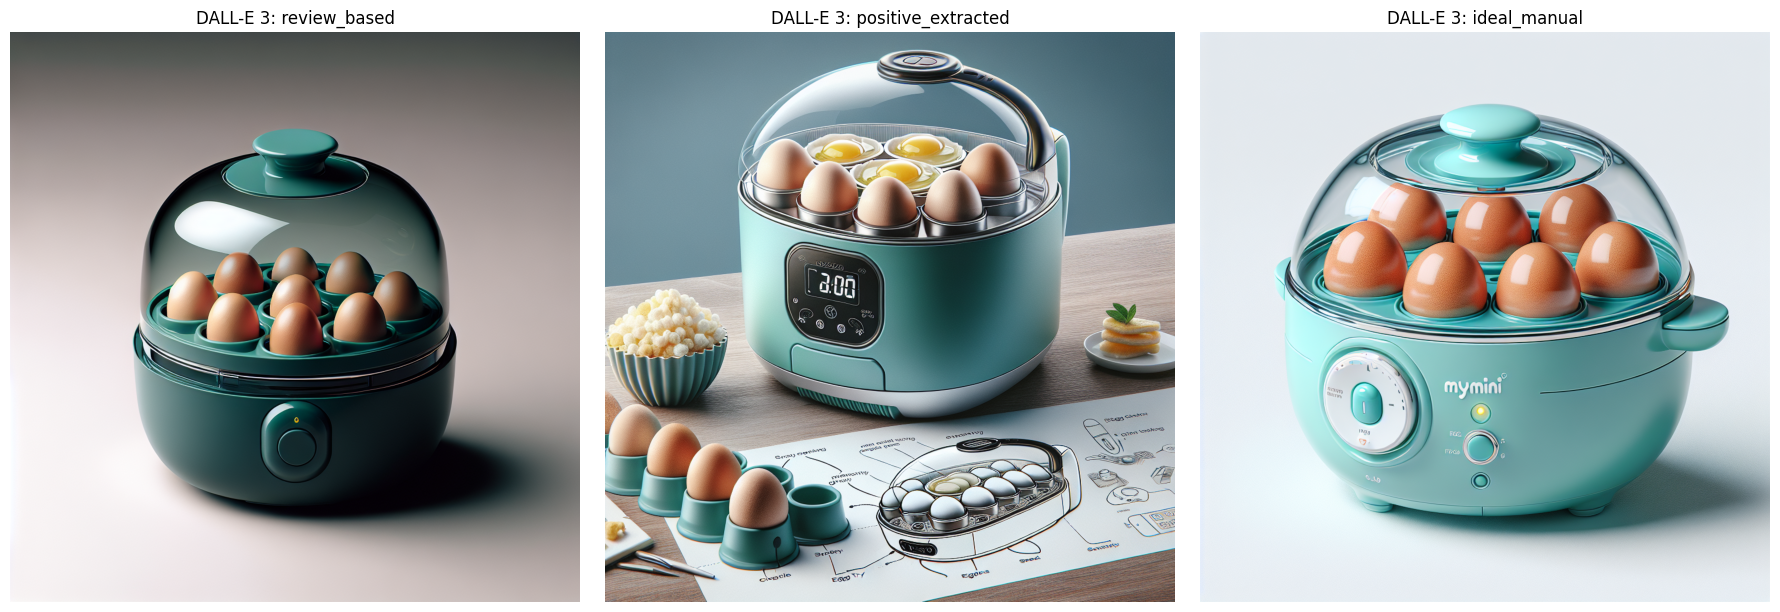

In [106]:
# Display DALL-E images
print("\n--- DALL-E 3 Results ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, (prompt_name, _) in enumerate(prompts.items()):
    img_path = f"{output_folder}/dalle3_{prompt_name}.png"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"DALL-E 3: {prompt_name}", fontsize=12)
        axes[idx].axis('off')
plt.tight_layout()
plt.savefig(f"{output_folder}/dalle3_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### Stable Diffusion


Generating: review_based...
Saved: sd_review_based.png

Generating: positive_extracted...
Saved: sd_positive_extracted.png

Generating: ideal_manual...
Saved: sd_ideal_manual.png

--- Stable Diffusion Results ---


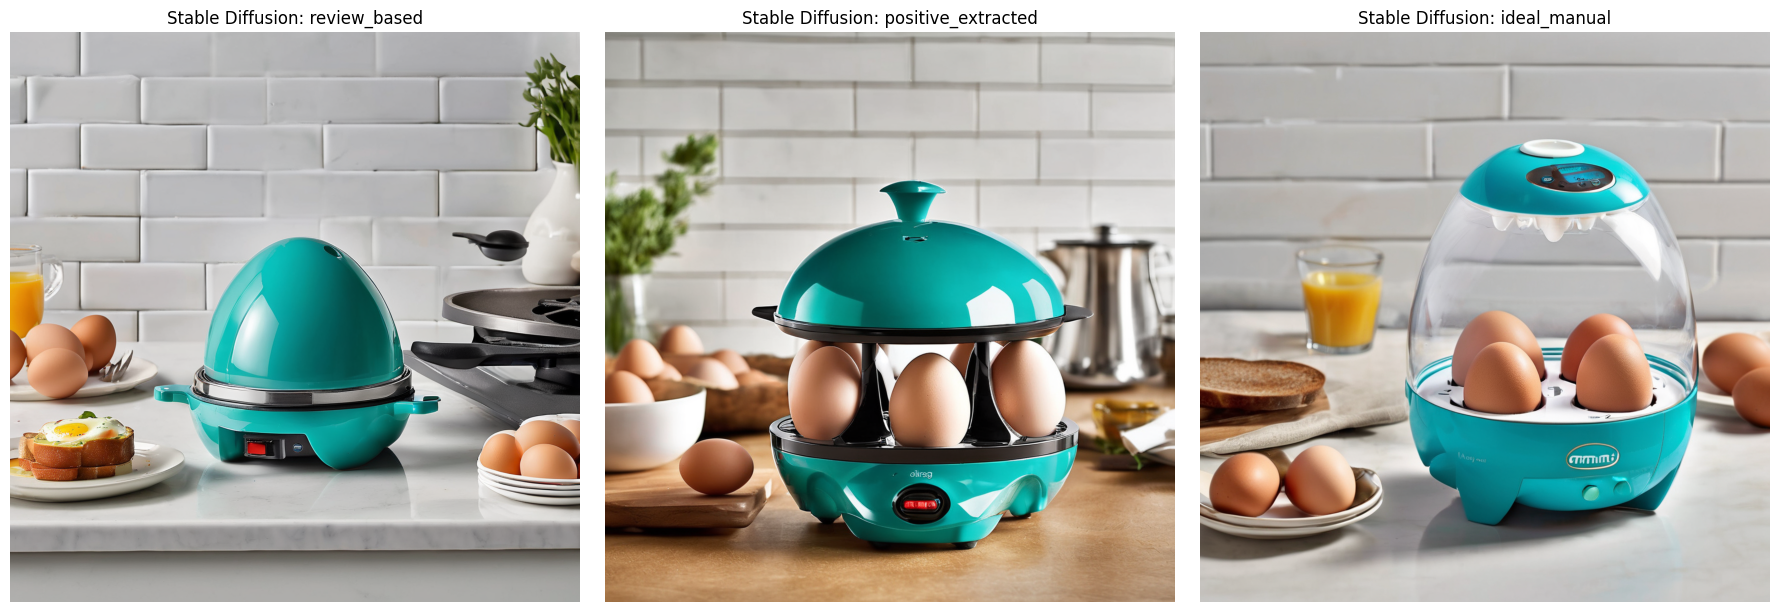

In [107]:
try:
    STABILITY_API_KEY = os.environ.get("STABILITY_API_KEY")
    

    sd_images = {}

    for prompt_name, prompt_text in prompts.items():
        print(f"\nGenerating: {prompt_name}...")

        response = requests.post(
            "https://api.stability.ai/v1/generation/stable-diffusion-xl-1024-v1-0/text-to-image",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {STABILITY_API_KEY}"
            },
            json={
                "text_prompts": [{"text": prompt_text, "weight": 1}],
                "cfg_scale": 7,
                "height": 1024,
                "width": 1024,
                "samples": 1,
                "steps": 30
            }
        )

        if response.status_code == 200:
            data = response.json()
            img_data = base64.b64decode(data["artifacts"][0]["base64"])
            img = Image.open(BytesIO(img_data))
            save_path = f"{output_folder}/sd_{prompt_name}.png"
            img.save(save_path)
            sd_images[prompt_name] = save_path
            print(f"Saved: sd_{prompt_name}.png")
        else:
            print(f"Error: {response.status_code} - {response.text}")

    # Display SD images
    print("\n--- Stable Diffusion Results ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for idx, (prompt_name, _) in enumerate(prompts.items()):
        img_path = f"{output_folder}/sd_{prompt_name}.png"
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Stable Diffusion: {prompt_name}", fontsize=12)
            axes[idx].axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_folder}/sd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"{str(e)}")

### Nano Banana


Generating (Imagen): review_based...
Saved: gimg_review_based.png

Generating (Imagen): positive_extracted...
Saved: gimg_positive_extracted.png

Generating (Imagen): ideal_manual...
Saved: gimg_ideal_manual.png

--- Imagen (Google GenAI) Results ---


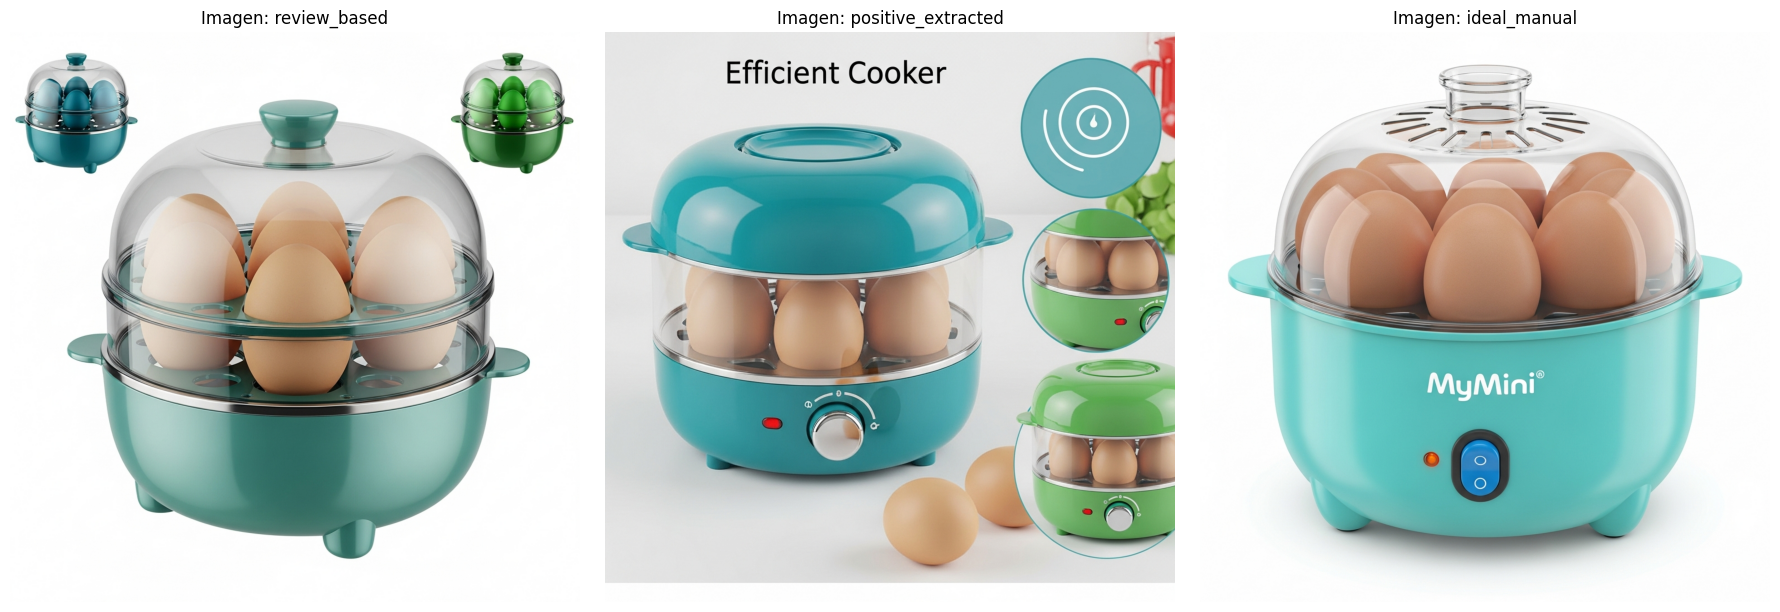

Comparison image saved to: generated_images/gimg_comparison.png


In [26]:
# !pip install google-genai
import os
from google import genai
from google.genai import types
from PIL import Image
import matplotlib.pyplot as plt

#
# output_folder = "/content/drive/MyDrive/GenAI/egg_cooker_images"

os.makedirs(output_folder, exist_ok=True)

# 初始化 Google GenAI 客户端（需要提前在环境变量中配置 GOOGLE_API_KEY）
client = genai.Client()

try:
    gimg_images = {}  # 记录每个 prompt 对应的保存路径

    # 逐个 prompt 生成并保存图片
    for prompt_name, prompt_text in prompts.items():
        print(f"\nGenerating (Imagen): {prompt_name}...")

        response = client.models.generate_images(
            model="imagen-4.0-generate-001",
            prompt=prompt_text,
            config=types.GenerateImagesConfig(
                number_of_images=1,  # 每个 prompt 只生成 1 张图，类似 SD 示例中的 samples=1
            ),
        )

        # 按照示例 1：response.generated_images 里是生成的图片对象
        if not response.generated_images:
            print(f"No images returned for prompt: {prompt_name}")
            continue

        generated_image = response.generated_images[0]

        # generated_image.image 在示例 1 中可以直接 .show()，说明是一个 PIL Image 或兼容对象
        img = generated_image.image  # 直接取出 PIL Image 对象

        # 保存路径仿照 Stable Diffusion 代码，换个前缀以示区分
        save_path = os.path.join(output_folder, f"gimg_{prompt_name}.png")
        img.save(save_path)
        gimg_images[prompt_name] = save_path

        print(f"Saved: gimg_{prompt_name}.png")

    # -----------------------------
    # 展示生成的图片（仿照 SD 部分的展示格式）
    # -----------------------------
    if len(gimg_images) == 0:
        print("No images were generated, nothing to display.")
    else:
        print("\n--- Imagen (Google GenAI) Results ---")

        prompt_names = list(prompts.keys())
        n = len(prompt_names)

        fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

        # 如果只有一个 prompt，axes 不是 list，需要特殊处理
        if n == 1:
            axes = [axes]

        for idx, prompt_name in enumerate(prompt_names):
            img_path = os.path.join(output_folder, f"gimg_{prompt_name}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Imagen: {prompt_name}", fontsize=12)
                axes[idx].axis("off")
            else:
                axes[idx].set_title(f"Missing: {prompt_name}", fontsize=12)
                axes[idx].axis("off")

        plt.tight_layout()
        comp_save_path = os.path.join(output_folder, "gimg_comparison.png")
        plt.savefig(comp_save_path, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Comparison image saved to: {comp_save_path}")

except Exception as e:
    print(f"Error while generating images with Imagen: {str(e)}")